In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import skimage.data as data
import skimage.segmentation as seg
from skimage import filters
from skimage import draw
from skimage import color
from skimage import exposure
from skimage import io
import skimage
import scipy as scpy
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

# SEGMENTATION #

In [426]:
def image_show(image, nrows=1, ncols=1, cmap='gray', **kwargs):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 6))
    ax.imshow(image, cmap='gray')
    #ax.axis('off')
    return fig, ax

In [427]:
image = io.imread('chicken_17_01_2023_high_res.bmp') 

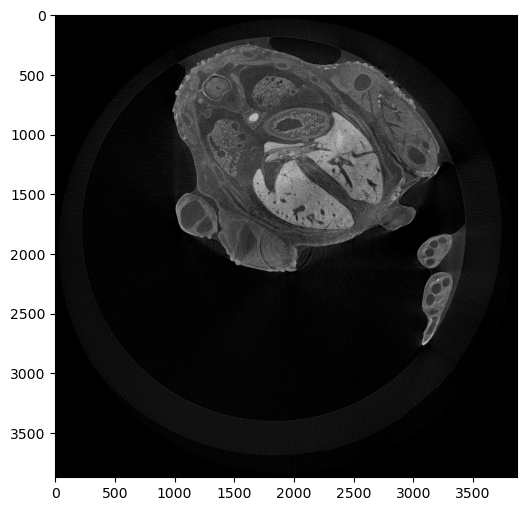

In [428]:
image_gray = image
image_show(image_gray);

In [429]:
image.max()

143

In [430]:
print(image_gray.min())
print(image_gray.max())
print(image_gray.mean())

0
143
12.956143732711222


In [431]:
#sns.histplot(data=np.ravel(image_gray), bins=30)

In [432]:
#image_gray[image_gray<45] = 0

In [433]:
#image_gray[image_gray>74] = 0

In [434]:
#image_show(image_gray);

In [435]:
#ppp = masked_liver*image_gray

In [436]:
#lpk = []
#for i in np.ravel(ppp):
#    if i != 0:
#        lpk.append(i)

In [437]:
#lpk = np.array(lpk)

In [438]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

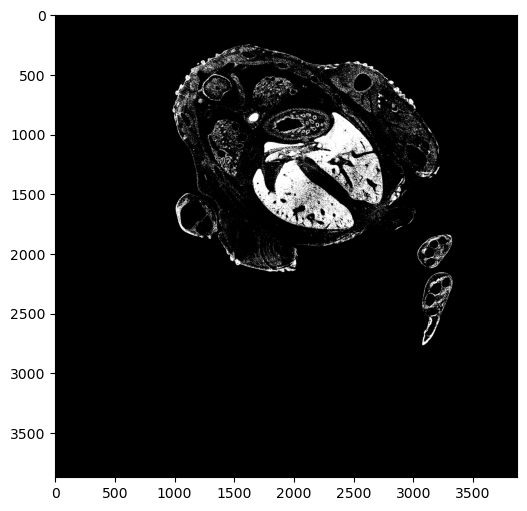

In [439]:
image_show(window_image(image_gray, 60, 10))

In [440]:
windowed_image = window_image(image_gray, 50, 10)

In [441]:
print(windowed_image.min())
print(windowed_image.max())
print(windowed_image.mean())

45
55
45.84196782846544


(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

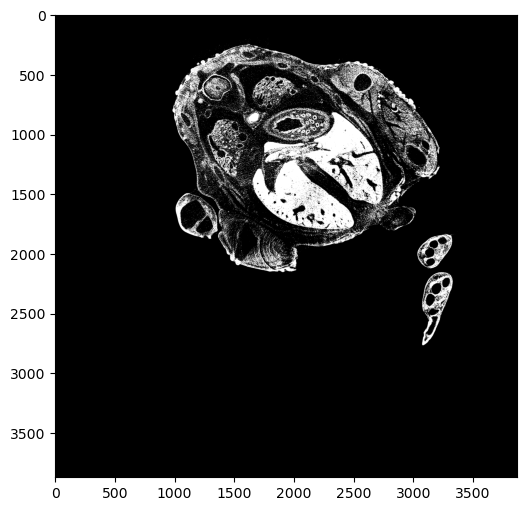

In [442]:
image_show(windowed_image)

In [443]:
windowed_image = windowed_image>47

In [444]:
windowed_image

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

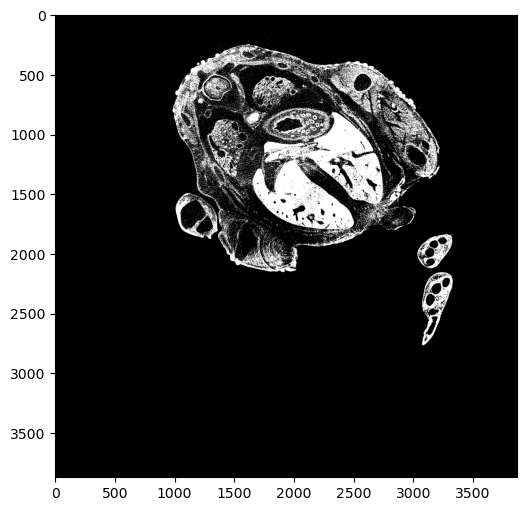

In [445]:
image_show(windowed_image)

In [446]:
#plt.imsave(arr=windowed_image, fname='thresholded_image.png', cmap='gray')

In [447]:
def remove_noise(image, window_center, window_width):

    windowed_image = window_image(image, window_center, window_width)
    #windowed_image = windowed_image>=41
    segmentation = skimage.morphology.dilation(windowed_image, np.ones((1, 1)))
    labels, label_nb = scpy.ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(int))
    label_count[0] = 0

    mask = labels == label_count.argmax()
 
    mask = skimage.morphology.dilation(mask, np.ones((1, 1)))
    mask = scpy.ndimage.binary_fill_holes(mask)
    mask = skimage.morphology.dilation(mask, np.ones((3, 3)))
    masked_image = mask * windowed_image
    
    return masked_image

In [499]:
filtered_image = remove_noise(image_gray, 55, 10)

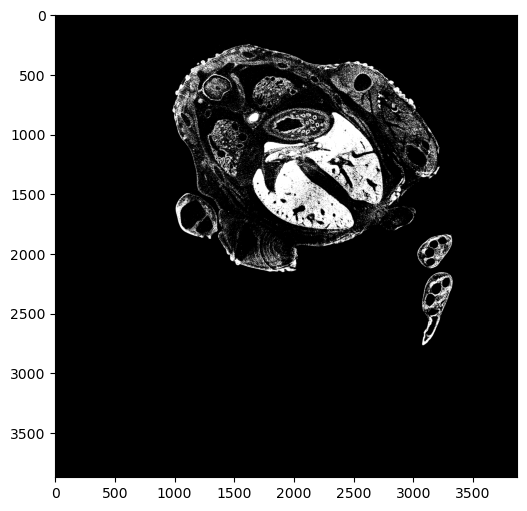

In [500]:
image_show(filtered_image);

In [501]:
contours = skimage.measure.find_contours(filtered_image)

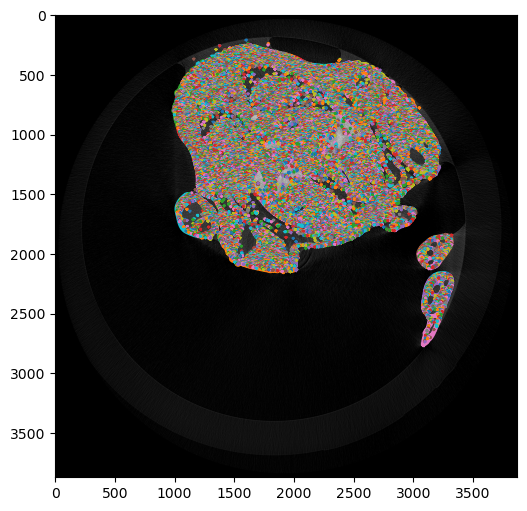

In [502]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image_gray, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

#ax.axis('image')
#ax.set_xticks([])
#ax.set_yticks([])
plt.show()

In [503]:
contours_1 = []
for contour in contours:
    if len(contour) > 15:
        contours_1.append(contour)

In [504]:
len(contours_1)

6513

In [505]:
def contour_distance(contour):
    """
    Given a set of points that may describe a contour
     it calculates the distance between the first and the last point
     to infer if the set is closed.
    """
    for i in range(0, len(contour)):
        dx = contour[i][0, 1] - contour[i][-1, 1]
        dy = contour[i][0, 0] - contour[i][-1, 0]
        
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

In [506]:
def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False

In [507]:
set_is_closed(contours_1)

True

In [508]:
def find_object(contours, volume_size):
    """
    Chooses the contours that correspond to the lungs and the body
    First, we exclude non-closed sets-contours
    Then we assume some min area and volume to exclude small contours
    Then the body is excluded as the highest volume closed set
    The remaining areas correspond to the lungs
    Args:
        contours: all the detected contours

    Returns: contours that correspond to the lung area
    """
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        hull = scpy.spatial.ConvexHull(contour)

       # set some constraints for the volume if the input is 2D the volume corresponds to the area
        if hull.volume > volume_size and set_is_closed(contours):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    return body_and_lung_contours # only lungs left !!!

In [513]:
maybe_liver = find_object(contours=contours_1, volume_size=200000)

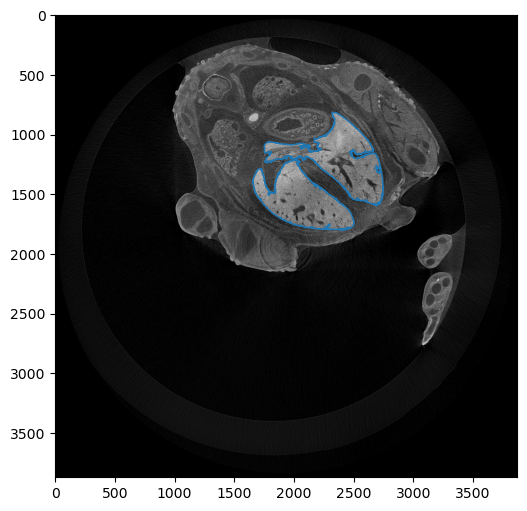

In [516]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image_gray, cmap=plt.cm.gray)
for contour in maybe_liver:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1.)
ax.axis('image')
#plt.savefig('contoured_liver.png', dpi=600, transparent=True)
plt.show()

In [517]:
from PIL import Image, ImageDraw

In [518]:
def create_mask_from_polygon(image, contours):
    """
    Creates a binary mask with the dimensions of the image and
    converts the list of polygon-contours to binary masks and merges them together
    Args:
        image: the image that the contours refer to
        contours: list of contours

    Returns:

    """
    liver_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        liver_mask += mask

    liver_mask[liver_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary
    return liver_mask.T  # transpose it to be aligned with the image dims

In [519]:
masked_liver = create_mask_from_polygon(image=image_gray, contours=maybe_liver)

In [520]:
masked_liver.shape

(3872, 3872)

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

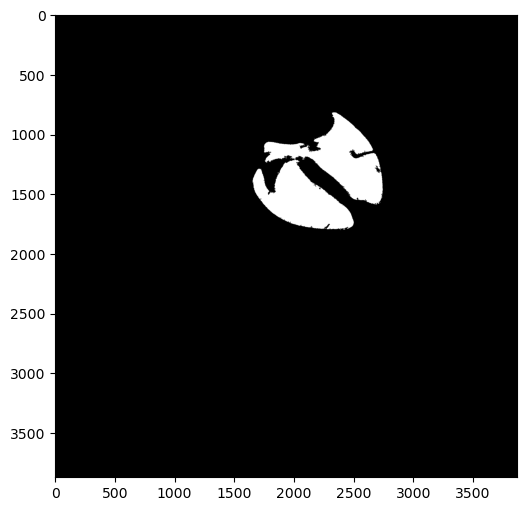

In [521]:
image_show(masked_liver)

In [523]:
#plt.imsave(arr=masked_liver, fname='masked_liver.png', cmap='gray')

In [524]:
np.unique(np.ravel(masked_liver), return_counts=True) 
#the area of the liver is the nuber of non-zero elements multiplied by the pixel size

(array([0, 1], dtype=uint8), array([14431604,   560780], dtype=int64))

In [525]:
def create_vessel_mask(liver_mask, ct_numpy, denoise=False):
    vessels = liver_mask * ct_numpy  #isolating liver area
    #vessels[vessels == 0] = 0
    vessels[(vessels > 0) & (vessels < 45)] = 1 #these are the vessels
    vessels[vessels >= 45] = 0 #here we want to exclude everything else
    
    #show_slice(vessels)
    if denoise:
        return denoise_vessels(liver_contour, vessels)
    #show_slice(vessels)
    return vessels

In [526]:
masked_vessels = create_vessel_mask(liver_mask=masked_liver, ct_numpy=image_gray, denoise=False)

In [527]:
print(masked_vessels.min())
print(masked_vessels.max())
print(masked_vessels.mean())

0
1
0.002837774165869818


(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

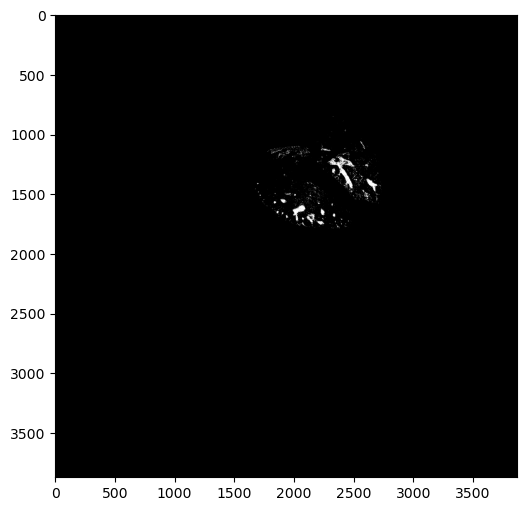

In [528]:
image_show(masked_vessels)

In [529]:
def overlay_plot(im, mask):
    plt.figure(figsize=(4,4))
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.55)

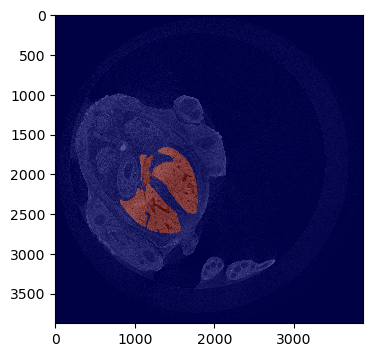

In [530]:
overlay_plot(im=image_gray, mask=masked_liver)

In [531]:
import os 

In [532]:
import glob

In [533]:
def segmentation(path, window_center=60, window_width=5, contour_lenght = 5, volume = 50000):
    
    all_masked_objects = []
    all_masked_vessels = []
    all_segmented_contours = []
    
    paths = sorted(glob.glob(path))
    for img in paths:
        img = io.imread(img)
        #image_show(img)
        
        windowed_image = window_image(img, window_center, window_width)
        
        filtered_image = remove_noise(img, window_center, window_width)
        
        contours = skimage.measure.find_contours(filtered_image)
        
        contours_1 = []
        for contour in contours:
            if len(contour) > contour_lenght:
                contours_1.append(contour)
        
        segmented_object = find_object(contours=contours_1, volume_size=volume)
        
        masked_object = create_mask_from_polygon(image=img, contours=segmented_object)
        
        masked_vessels = create_vessel_mask(liver_mask=masked_object, ct_numpy=img)
        
        object_values, object_counts = np.unique(np.ravel(masked_object), return_counts=True)
        vessels_values, vessels_counts = np.unique(np.ravel(masked_vessels), return_counts=True)
        
        all_segmented_contours.append(segmented_object)
        all_masked_objects.append(masked_object)
        all_masked_vessels.append(masked_vessels)

    return all_masked_objects, all_masked_vessels, all_segmented_contours

In [543]:
masked_object, masked_vessels, contours = segmentation(path='trial/*', window_center=60, window_width=10, 
                                             contour_lenght=15, volume=100000)

In [535]:
#contours

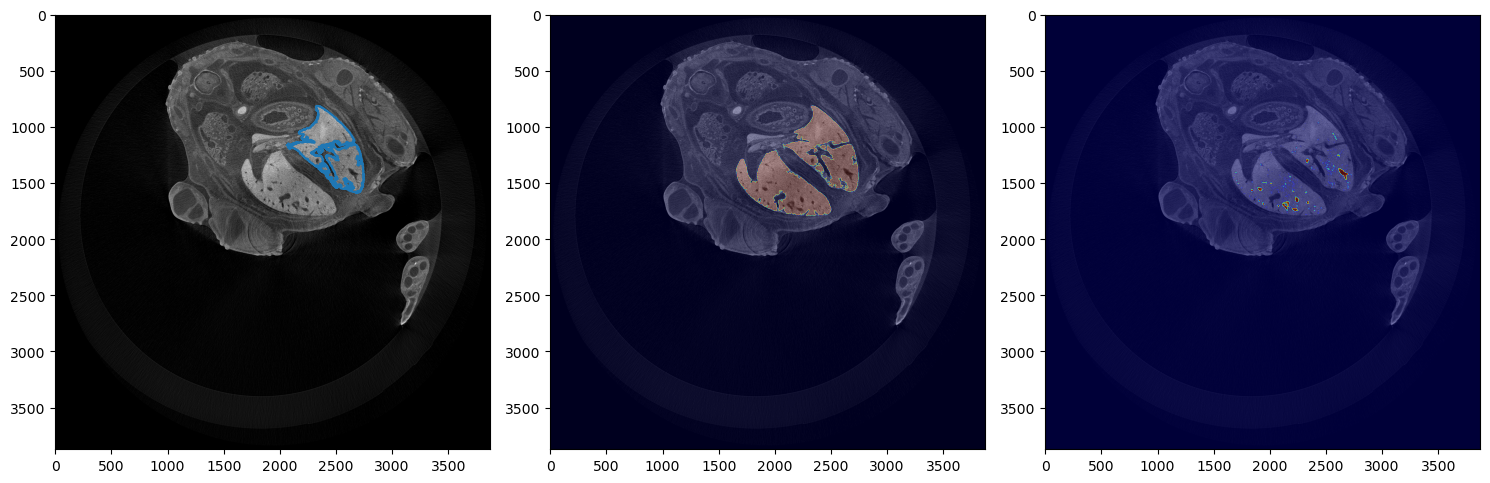

In [544]:
#SEGMENTED IMAGES VISUALIZATIONS FOR A SINGLE IMAGE

image = io.imread('trial/chicken_17_01_2023_high_res.bmp') 
#image = color.rgb2gray(image)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].plot(contours[0][0][:, 1], contours[0][0][:, 0], linewidth=1.5)
ax[1].imshow(image, cmap=plt.cm.gray)
ax[1].imshow(masked_object[0], cmap='jet', alpha=0.25)
ax[2].imshow(image, cmap=plt.cm.gray)
ax[2].imshow(masked_vessels[0], cmap='jet', alpha=0.45)
plt.tight_layout()
plt.show()

In [545]:
liver_values, liver_counts = np.unique(np.ravel(masked_object[0]), return_counts=True)
vessel_values, vessel_counts = np.unique(np.ravel(masked_vessels[0]), return_counts=True)

In [546]:
print('Liver area, mm^2:', np.round(liver_counts[1]*4.22/1000, 1))
print('Vessels area, mm^2', np.round(vessel_counts[1]*4.22/1000, 1))

Liver area, mm^2: 1961.0
Vessels area, mm^2 74.1


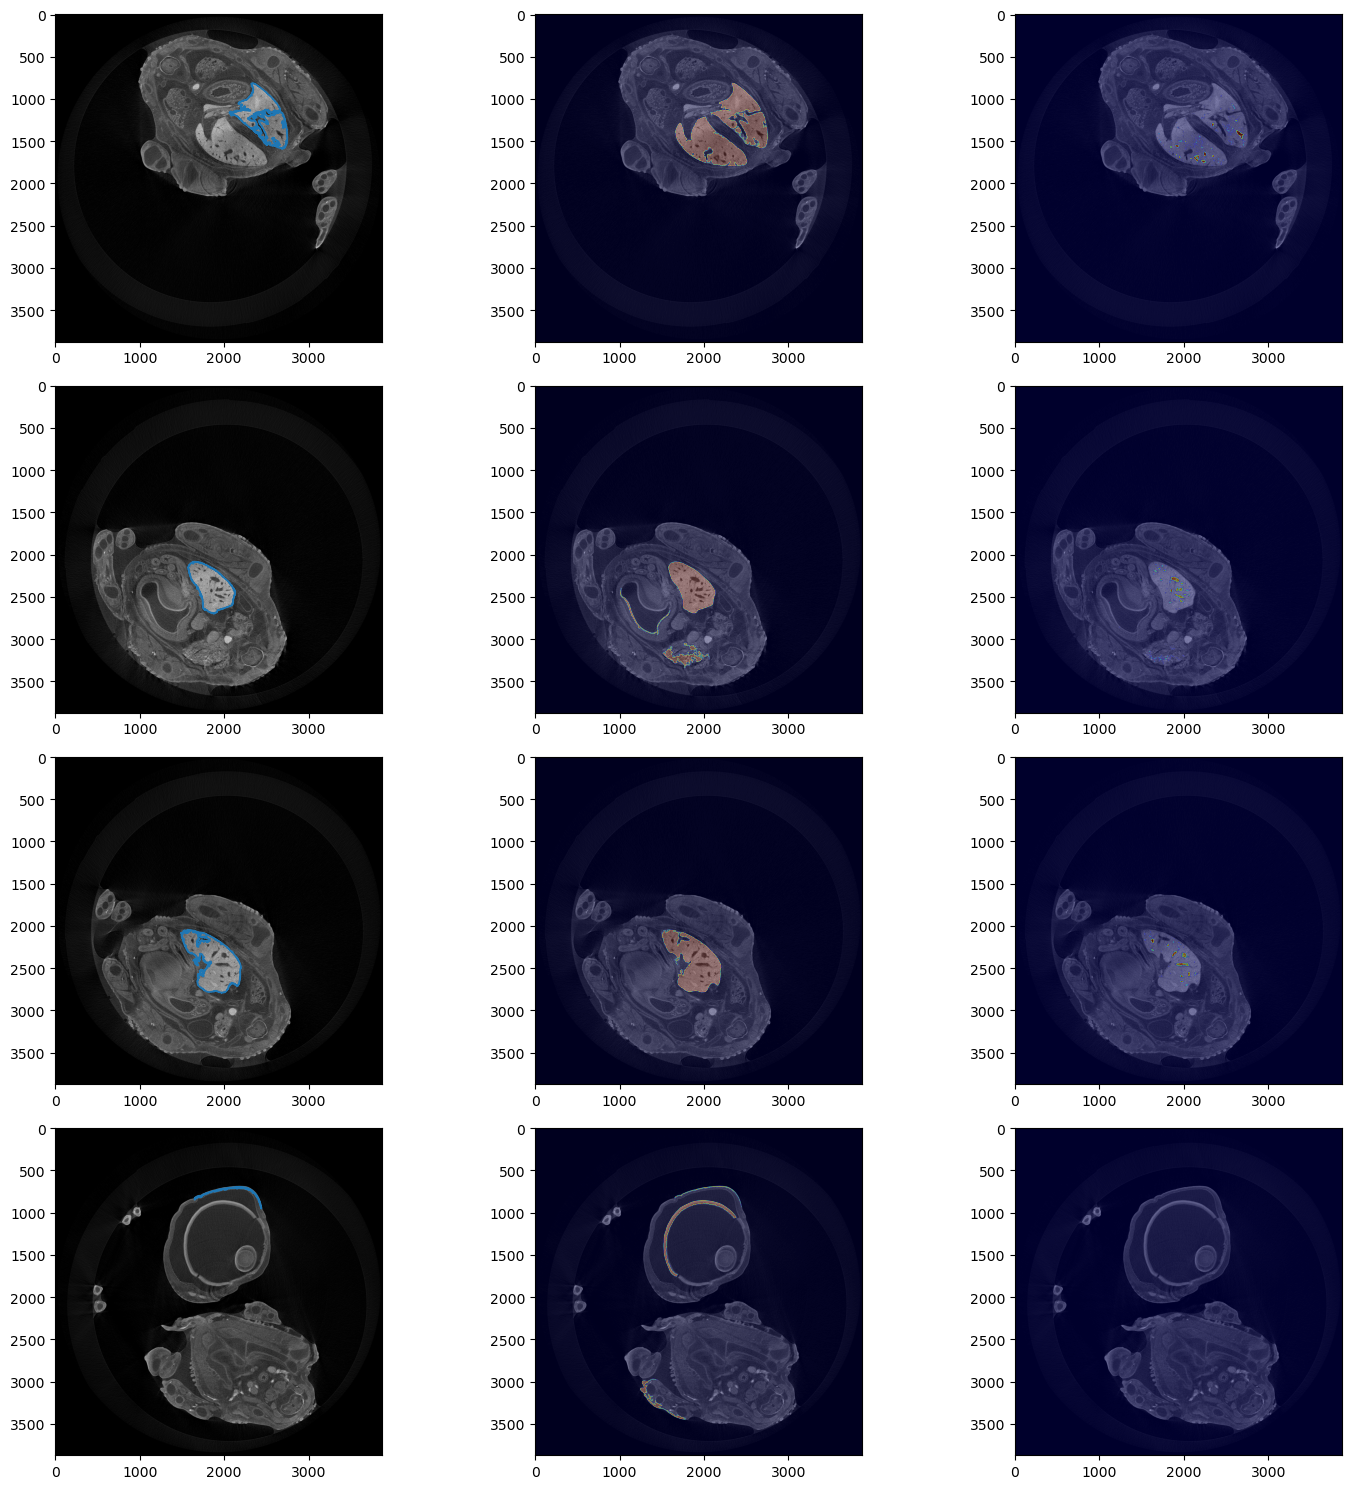

In [547]:
path = sorted(glob.glob('trial/*'))
cols = 3
fig, axes = plt.subplots(nrows=len(path), ncols=cols, figsize=(15, 15))
image_list = []
for img in path:
    #print(img)
    img = io.imread(img) 
    image_list.append(img)
for num, ax in enumerate(axes):
    ax[0].imshow(image_list[num], cmap=plt.cm.gray)
    ax[0].plot(contours[num][0][:, 1], contours[num][0][:, 0], linewidth=1.2)
    ax[1].imshow(image_list[num], cmap=plt.cm.gray)
    ax[1].imshow(masked_object[num], cmap='jet', alpha=0.25)
    ax[2].imshow(image_list[num], cmap=plt.cm.gray)
    ax[2].imshow(masked_vessels[num], cmap='jet', alpha=0.35)

plt.tight_layout()
#plt.savefig('images.png', dpi=600, transparent=True)

In [139]:
def volume(masked_object, pixel_size, number_of_slices = 1):
    area_list = []
    volume_list = []
    for i in masked_object:
        object_values, object_counts = np.unique(np.ravel(i), return_counts=True)
        area = np.round(object_counts[1]*pixel_size/1000, 1)
        volume = area*number_of_slices
        area_list.append(area)
        volume_list.append(volume)
    volume = np.round(np.sum(np.array(volume_list)), 3)
    return area_list, volume

In [140]:
volume(masked_object=masked_object, pixel_size=10)

([1986.9, 1999.9, 2481.9, 2850.2], 9318.9)

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from skimage import io

In [142]:
full_img = io.imread('trial/chicken_17_01_2023_rec0042.bmp')

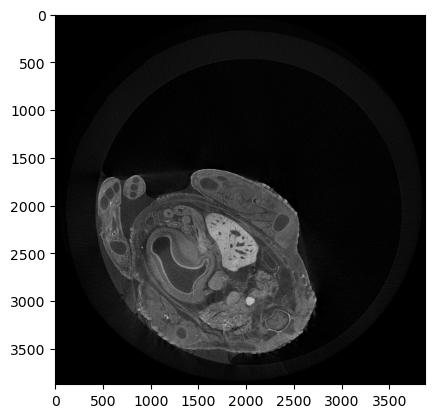

In [143]:
plt.imshow(full_img, cmap='gray')

In [144]:
img = full_img#[1500:3700, 300:2750]

In [145]:
training_labels = np.zeros(img.shape, dtype=np.uint8)

In [146]:
training_labels=training_labels+masked_object[0]

In [147]:
training_labels[3000:3300, 1750:2000] = 2

In [148]:
training_labels[2750:3000, 1500:1700] = 3

In [149]:
#training_labels[1150:1300, 952:1200] = 3 

In [150]:
np.unique(training_labels)

array([0, 1, 2, 3], dtype=uint8)

In [151]:
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,)
                        #channel_axis=None)

In [152]:
features = features_func(img)

In [153]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                             max_depth=10, max_samples=0.05, min_samples_split=3)

In [154]:
clf = future.fit_segmenter(training_labels, features, clf)

In [155]:
result = future.predict_segmenter(features, clf)

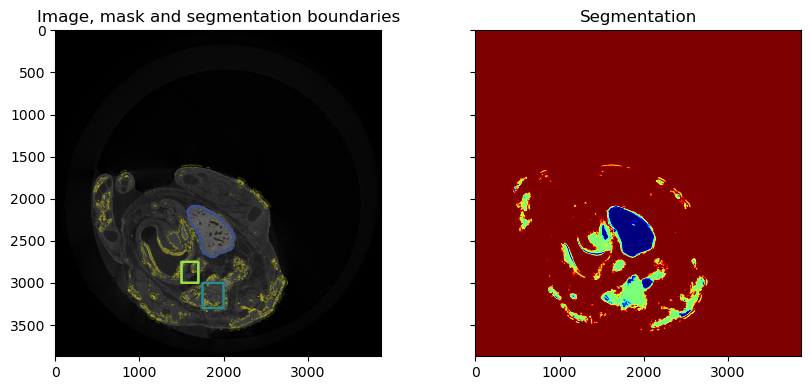

In [156]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result, cmap='jet')
ax[1].set_title('Segmentation')
fig.tight_layout()